In [12]:
import os
import pickle
import glob
import sys
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

# user path:
usrname = getpass.getuser()
# add paths:
sys.path.append(f'/Users/{usrname}/Desktop/Projects')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/bimanual_wrist')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/Functional_Fusion')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/PcmPy')


import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# Build dataset

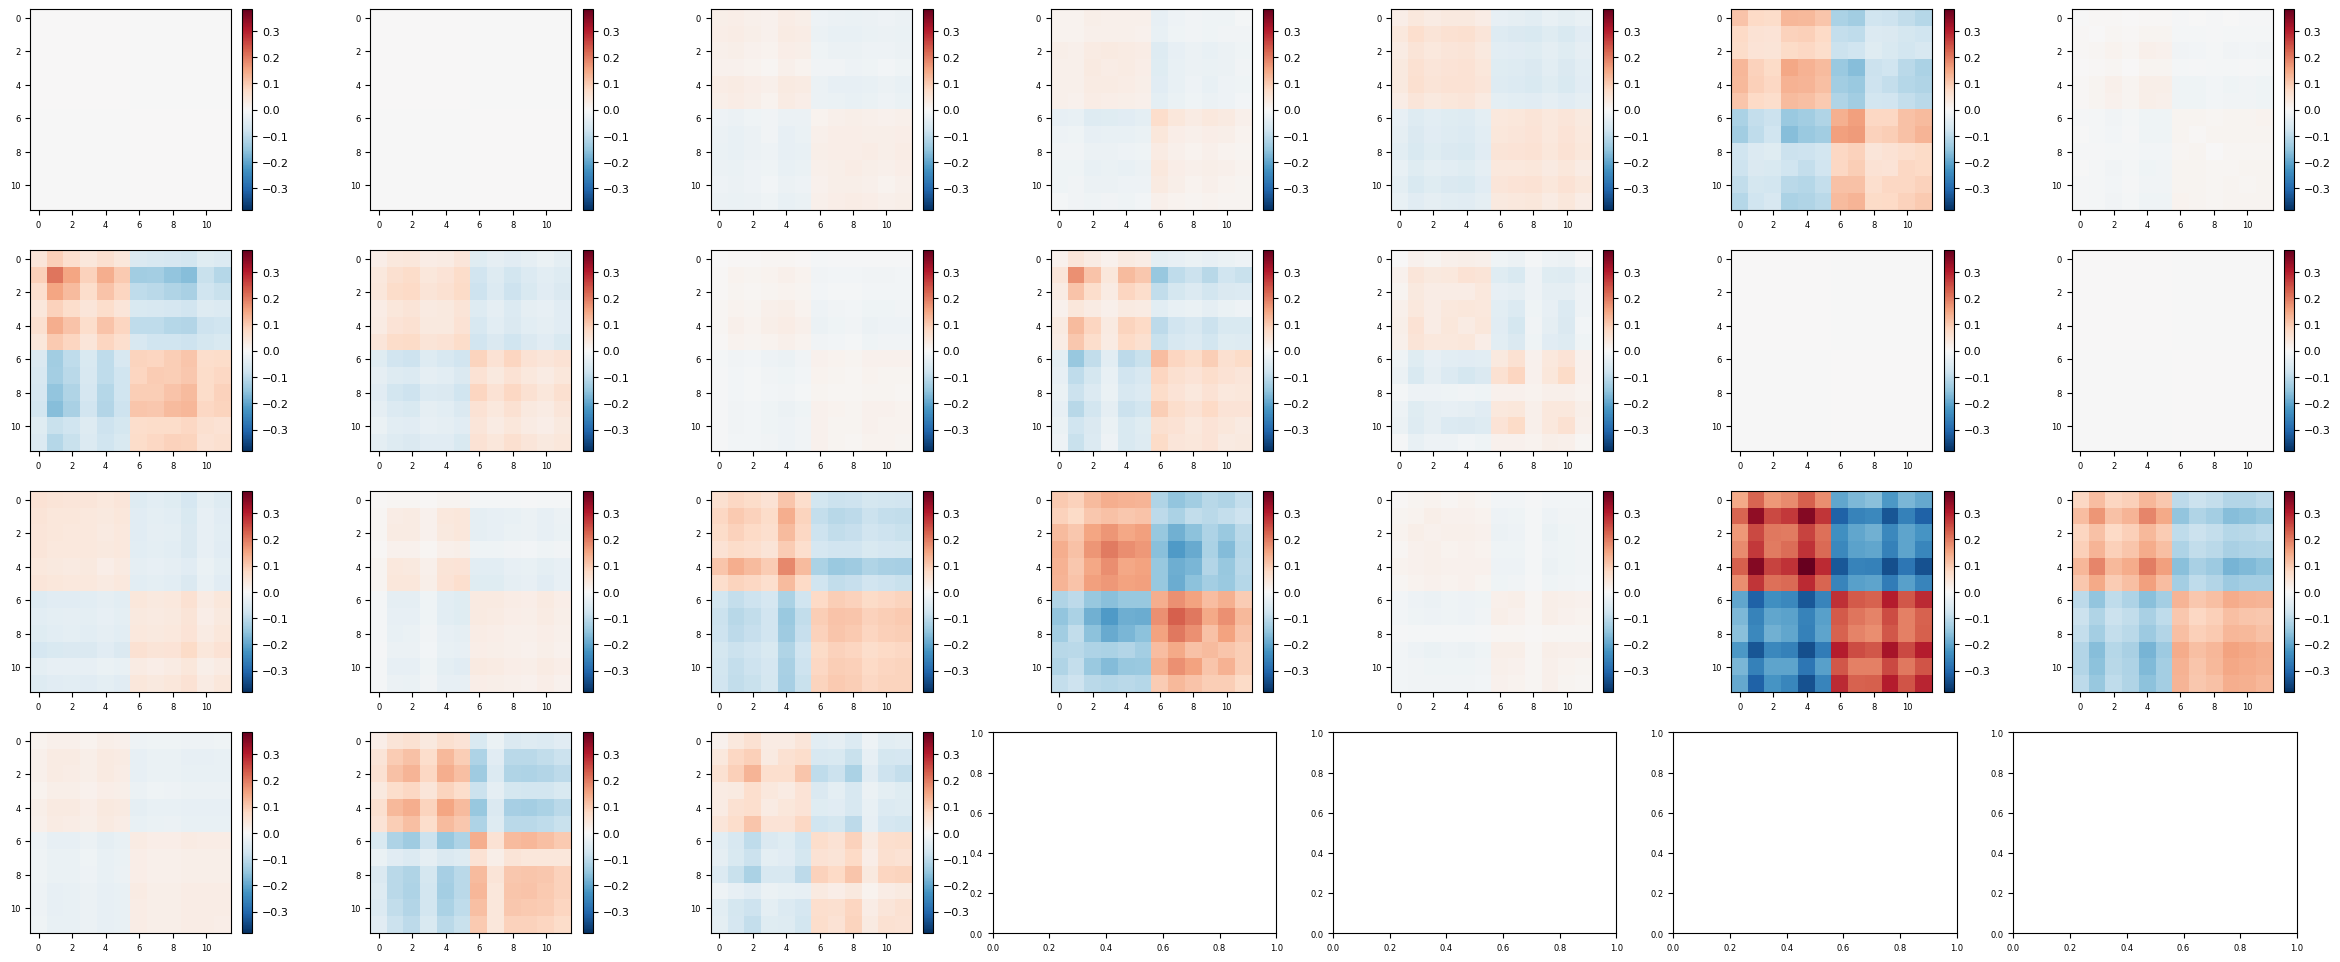

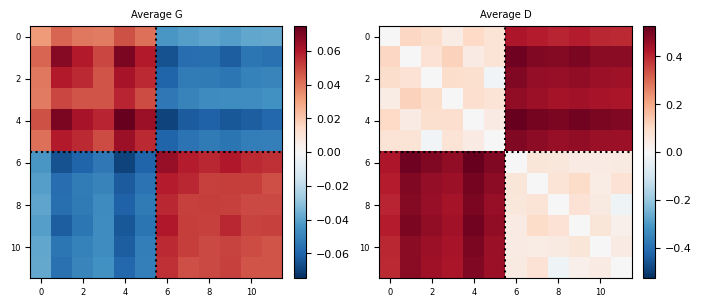

In [45]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
labels_lateral = ['contra']*6 + ['ipsi']*6
cmap = 'RdBu_r'
sn_bad = [102, 103]
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
hem = ['L','R']

region = regions[0]
data, cond_vec, part_vec = [], [], []
for i_hem, h in enumerate(hem):
    roi = f'{region}_{h}'
    file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
    d = np.load(file_path, allow_pickle=True)

    subject = d['subject']
    indices = [k for k, s in enumerate(subject) if s not in sn_bad]

    subject = d['subject'][indices]
    cond_name_tmp = d['cond_intrinsic_vec'][indices]
    cond_vec_tmp = d['cond_num_vec'][indices]
    data_tmp = d['beta_white'][indices]
    part_tmp = d['part_vec'][indices]

    for i_sub in range(len(subject)):
        idx1 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'rhand' in c]
        idx2 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'lhand' in c]
        idx = idx1 + idx2
        # Y = data_tmp[i_sub][idx, :]
        Y1 = data_tmp[i_sub][idx1, :]
        Y2 = data_tmp[i_sub][idx2, :]

        # remove mean of voxels across conditions of rhand:
        # rhand_parts = part_tmp[i_sub][idx1]
        # for p in np.unique(rhand_parts):
        #     Y1[rhand_parts == p, :] = Y1[rhand_parts == p, :] - np.mean(Y1[rhand_parts == p, :], axis=0)
        # # remove mean of voxels across conditions of lhand:
        # lhand_parts = part_tmp[i_sub][idx2]
        # for p in np.unique(lhand_parts):
        #     Y2[lhand_parts == p, :] = Y2[lhand_parts == p, :] - np.mean(Y2[lhand_parts == p, :], axis=0)
        Y = np.vstack((Y1, Y2))
        
        subj_part = part_tmp[i_sub][idx]
        # Sort based on Hemisphere to have contralateral first:
        if h == 'L':
            subj_cond = cond_vec_tmp[i_sub][idx]
            tmp = subj_cond.copy()
            subj_cond[tmp > 5] = tmp[tmp > 5] - 6
            subj_cond[tmp <= 5] = tmp[tmp <= 5] + 6 
        elif h == 'R':
            subj_cond = cond_vec_tmp[i_sub][idx]

        data.append(Y)
        cond_vec.append(np.array(subj_cond))
        part_vec.append(subj_part)

Y = []
# --- RDM Calculation ---
for i_sub in range(len(data)):
    obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
    Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

N = len(Y)
ncond = len(np.unique(Y[0].obs_descriptors['cond_vec']))
G_hat = np.zeros((N, ncond, ncond))
for i_sub in range(N):
    G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                Y[i_sub].obs_descriptors['cond_vec'],
                                                Y[i_sub].obs_descriptors['part_vec'],
                                                X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))

# show all second moment matrices
cmap = 'RdBu_r'
fig,ax = plt.subplots(4,7,figsize=(30,12))
vmax = np.abs(G_hat).max()
for i in range(N):
    ax[i//7,i%7].imshow(G_hat[i,:,:],vmin=-vmax,vmax=vmax,cmap=cmap)
    # color bar:
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax[i//7,i%7], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)

# avg:
fig, ax = plt.subplots(1,2,figsize=(7,3))
G_hat_avg = np.mean(G_hat, axis=0)
# G_hat_avg = G_hat_avg / np.trace(G_hat_avg)
vmax_avg = np.abs(G_hat_avg).max()
ax[0].imshow(G_hat_avg, vmin=-vmax_avg, vmax=vmax_avg, cmap=cmap)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax_avg, vmax=vmax_avg))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[0], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
ax[0].set_title(f'Average G')
ax[0].axhline(5.5, color='k', linestyle=':', linewidth=1.5)
ax[0].axvline(5.5, color='k', linestyle=':', linewidth=1.5)

D_avg = pcm.G_to_dist(G_hat_avg)
D_avg = np.sign(D_avg) * np.sqrt(np.abs(D_avg))
vmax = np.abs(D_avg).max()
ax[1].imshow(D_avg, vmin=-vmax, vmax=vmax, cmap=cmap)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[1], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
ax[1].set_title(f'Average D')
ax[1].axhline(5.5, color='k', linestyle=':', linewidth=1.5)
ax[1].axvline(5.5, color='k', linestyle=':', linewidth=1.5)
plt.tight_layout()
plt.show() 

# save PCM dataset (Y):
file_path_save = os.path.join(analysisDir, f'pcm_dataset_12by12_{region}.npz')
np.savez(file_path_save, Y=Y, cond_vec=cond_vec, part_vec=part_vec)

# save mean G:
file_path_save = os.path.join(analysisDir, f'pcm_Ghat_avg_12by12_{region}.npz')
np.savez(file_path_save, G_hat=G_hat_avg)



# Build models

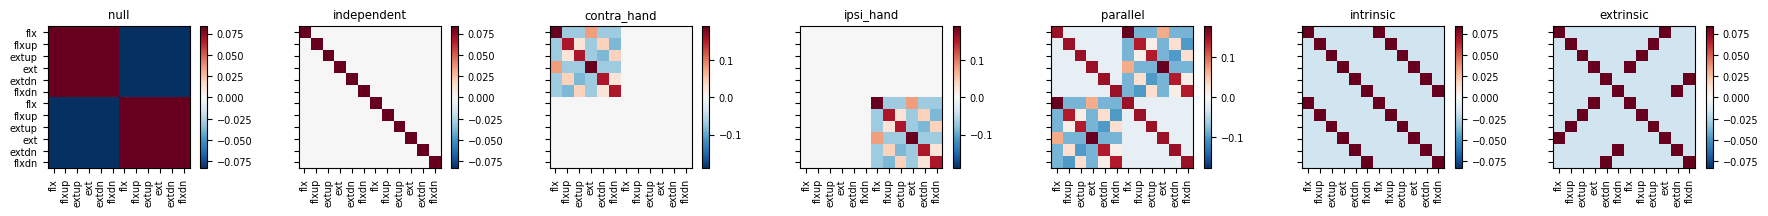

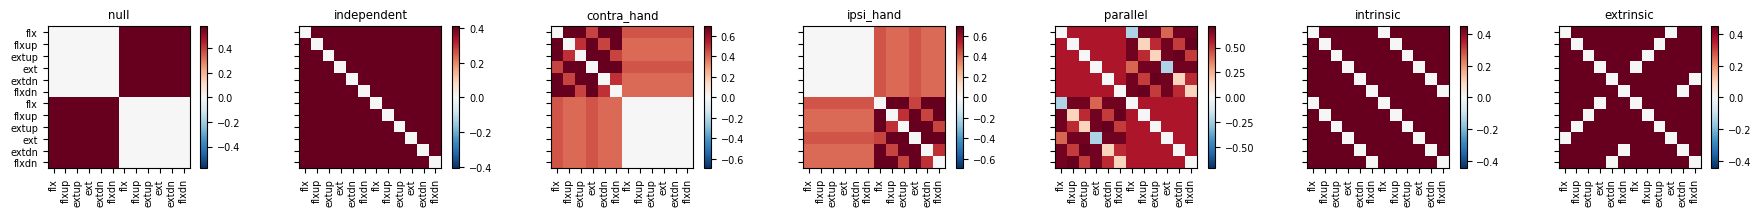

In [22]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
labels_lateral = ['contra']*6 + ['ipsi']*6
ncond = 12

M = []
modelG = {}

# Null model
# cov = np.zeros((ncond, ncond))
# M.append(pcm.FixedModel('null', cov))

# Simple hand model:
cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = 1
cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
cov = cov / np.trace(cov)
modelG['null'] = [cov]
M.append(pcm.FixedModel('null', cov))

# independent:
cov = np.eye(ncond) / ncond
modelG['independent'] = [cov]
M.append(pcm.FixedModel('independent', cov))

# Best model from unimanual direction encoding:
file_path = os.path.join(analysisDir, f'pcm_Ghat_best_within_model_{region}.npz')
data = np.load(file_path)
G_mdl = data['G_hat']
G_mdl = G_mdl / np.trace(G_mdl)

cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = G_mdl
# M.append(pcm.FixedModel('contra hand', cov))
modelG['contra_hand'] = [cov]

# Ipsi hand structure:
cov = np.zeros((ncond, ncond))
cov[6:12, 6:12] = G_mdl
# M.append(pcm.FixedModel('ipsi hand', cov))
modelG['ipsi_hand'] = [cov]

# Parallel contra-ipsi:
cov = np.eye(ncond) / 6
cov[0:6, 6:12] = G_mdl
cov[6:12, 0:6] = G_mdl
# cov = np.tile(G_ceil, (2,2))
# M.append(pcm.FixedModel('orth translation', cov))
cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
modelG['parallel'] = [cov]

# intrinsic contra-ipsi relationship:
cov = np.eye(ncond)
cov[0:6, 6:12] = np.eye(6)
cov[6:12, 0:6] = np.eye(6)
cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
cov = cov / np.trace(cov)
modelG['intrinsic'] = [cov]

# extrinsic contra-ipsi relationship:
mask_extrinsic = np.zeros((6,6)) # picking the extrinsicly similar conditions (moving to the same direction in space): e.g., flxup:extup, extdn:flxdn, ...
mask_extrinsic[0,3] = 1
mask_extrinsic[3,0] = 1
mask_extrinsic[1,2] = 1
mask_extrinsic[2,1] = 1
mask_extrinsic[4,5] = 1
mask_extrinsic[5,4] = 1
cov = np.eye(ncond)
cov[0:6, 6:12] = mask_extrinsic
cov[6:12, 0:6] = mask_extrinsic
cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
cov = cov / np.trace(cov)
modelG['extrinsic'] = [cov]

# component models:
M.append(pcm.ComponentModel('orthogonal', [modelG['null'][0],modelG['independent'][0],modelG['contra_hand'][0], modelG['ipsi_hand'][0]]))
M.append(pcm.ComponentModel('parallel', [modelG['null'][0],modelG['independent'][0],modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['parallel'][0]]))
M.append(pcm.ComponentModel('intrinsic', [modelG['null'][0],modelG['independent'][0],modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['intrinsic'][0]]))
M.append(pcm.ComponentModel('extrinsic', [modelG['null'][0],modelG['independent'][0],modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['extrinsic'][0]]))
M.append(pcm.ComponentModel('intrinsic+extrinsic', [modelG['null'][0],modelG['independent'][0],modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['intrinsic'][0], modelG['extrinsic'][0]]))

# noise ceiling model:
M_ceil = pcm.FreeModel('ceil',ncond)
M.append(M_ceil)

# PLOT:
n = len(modelG)
plt.rcParams.update({'font.size': 7})
fix, ax = plt.subplots(1,n, figsize=(18,2), sharey=True)
for i in range(n):
    vmin = -np.max(np.abs(modelG[list(modelG.keys())[i]]))
    vmax = np.max(np.abs(modelG[list(modelG.keys())[i]]))
    ax[i].imshow(modelG[list(modelG.keys())[i]][0], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(list(modelG.keys())[i])
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(modelG[list(modelG.keys())[i]][0], cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.tight_layout()
plt.show()

fix, ax = plt.subplots(1,n, figsize=(18,2), sharey=True)
for i in range(n):
    D = pcm.G_to_dist(modelG[list(modelG.keys())[i]][0])
    D = np.sign(D) * np.sqrt(np.abs(D))
    vmin = -np.max(np.abs(D))
    vmax = np.max(np.abs(D))
    ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(list(modelG.keys())[i])
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.tight_layout()
plt.show()




# Fit models

In [42]:
import pickle

# fit model:
T_gr, theta_gr = pcm.fit_model_group(Y, M, fixed_effect='block', fit_scale=True, verbose=True)
T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fixed_effect='block', fit_scale=True, verbose=True)

results = {
            'T_gr': T_gr, 'theta_gr': theta_gr,
            'T_cv': T_cv, 'theta_cv': theta_cv
            }
with open(os.path.join(analysisDir, f'PCM_unimanual_{region}.pkl'), 'wb') as f:
    pickle.dump(results, f)




Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6


# Fill all regions

In [44]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
labels_lateral = ['contra']*6 + ['ipsi']*6
ncond = 12
cmap = 'RdBu_r'
sn_bad = [102, 103]
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
hem = ['L','R']

for region in regions:
    print(f'======================= processing {region} =======================')
    # =============================== BUILD DATASET ===============================
    data, cond_vec, part_vec = [], [], []
    for i_hem, h in enumerate(hem):
        roi = f'{region}_{h}'
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]

        subject = d['subject'][indices]
        cond_name_tmp = d['cond_intrinsic_vec'][indices]
        cond_vec_tmp = d['cond_num_vec'][indices]
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]

        for i_sub in range(len(subject)):
            idx1 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'rhand' in c]
            idx2 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'lhand' in c]
            idx = idx1 + idx2
            # Y = data_tmp[i_sub][idx, :]
            Y1 = data_tmp[i_sub][idx1, :]
            Y2 = data_tmp[i_sub][idx2, :]

            # remove mean of voxels across conditions of rhand:
            # rhand_parts = part_tmp[i_sub][idx1]
            # for p in np.unique(rhand_parts):
            #     Y1[rhand_parts == p, :] = Y1[rhand_parts == p, :] - np.mean(Y1[rhand_parts == p, :], axis=0)
            # # remove mean of voxels across conditions of lhand:
            # lhand_parts = part_tmp[i_sub][idx2]
            # for p in np.unique(lhand_parts):
            #     Y2[lhand_parts == p, :] = Y2[lhand_parts == p, :] - np.mean(Y2[lhand_parts == p, :], axis=0)
            Y = np.vstack((Y1, Y2))
            
            subj_part = part_tmp[i_sub][idx]
            # Sort based on Hemisphere to have contralateral first:
            if h == 'L':
                subj_cond = cond_vec_tmp[i_sub][idx]
                tmp = subj_cond.copy()
                subj_cond[tmp > 5] = tmp[tmp > 5] - 6
                subj_cond[tmp <= 5] = tmp[tmp <= 5] + 6 
            elif h == 'R':
                subj_cond = cond_vec_tmp[i_sub][idx]

            data.append(Y)
            cond_vec.append(np.array(subj_cond))
            part_vec.append(subj_part)

    Y = []
    # --- making datasets ---
    for i_sub in range(len(data)):
        obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
        Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

    # =============================== BUILD MODELS ===============================
    M = []
    modelG = {}

    # Null model
    # cov = np.zeros((ncond, ncond))
    # M.append(pcm.FixedModel('null', cov))

    # Simple hand model:
    cov = np.zeros((ncond, ncond))
    cov[0:6, 0:6] = 1
    cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
    cov = cov / np.trace(cov)
    modelG['null'] = [cov]
    M.append(pcm.FixedModel('null', cov))

    # independent:
    cov = np.eye(ncond) / ncond
    modelG['independent'] = [cov]
    M.append(pcm.FixedModel('independent', cov))

    # Best model from unimanual direction encoding:
    file_path = os.path.join(analysisDir, f'pcm_Ghat_best_within_model_{region}.npz')
    data = np.load(file_path)
    G_mdl = data['G_hat']
    G_mdl = G_mdl / np.trace(G_mdl)

    cov = np.zeros((ncond, ncond))
    cov[0:6, 0:6] = G_mdl
    # M.append(pcm.FixedModel('contra hand', cov))
    modelG['contra_hand'] = [cov]

    # Ipsi hand structure:
    cov = np.zeros((ncond, ncond))
    cov[6:12, 6:12] = G_mdl
    # M.append(pcm.FixedModel('ipsi hand', cov))
    modelG['ipsi_hand'] = [cov]

    # Parallel contra-ipsi:
    cov = np.eye(ncond) / 6
    cov[0:6, 6:12] = G_mdl
    cov[6:12, 0:6] = G_mdl
    # cov = np.tile(G_ceil, (2,2))
    # M.append(pcm.FixedModel('orth translation', cov))
    cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
    modelG['parallel'] = [cov]

    # intrinsic contra-ipsi relationship:
    cov = np.eye(ncond)
    cov[0:6, 6:12] = np.eye(6)
    cov[6:12, 0:6] = np.eye(6)
    cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
    cov = cov / np.trace(cov)
    modelG['intrinsic'] = [cov]

    # extrinsic contra-ipsi relationship:
    mask_extrinsic = np.zeros((6,6)) # picking the extrinsicly similar conditions (moving to the same direction in space): e.g., flxup:extup, extdn:flxdn, ...
    mask_extrinsic[0,3] = 1
    mask_extrinsic[3,0] = 1
    mask_extrinsic[1,2] = 1
    mask_extrinsic[2,1] = 1
    mask_extrinsic[4,5] = 1
    mask_extrinsic[5,4] = 1
    cov = np.eye(ncond)
    cov[0:6, 6:12] = mask_extrinsic
    cov[6:12, 0:6] = mask_extrinsic
    cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
    cov = cov / np.trace(cov)
    modelG['extrinsic'] = [cov]

    # component models:
    M.append(pcm.ComponentModel('orthogonal', [modelG['null'][0],modelG['independent'][0],modelG['contra_hand'][0], modelG['ipsi_hand'][0]]))
    M.append(pcm.ComponentModel('parallel', [modelG['null'][0],modelG['independent'][0],modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['parallel'][0]]))
    M.append(pcm.ComponentModel('intrinsic', [modelG['null'][0],modelG['independent'][0],modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['intrinsic'][0]]))
    M.append(pcm.ComponentModel('extrinsic', [modelG['null'][0],modelG['independent'][0],modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['extrinsic'][0]]))
    M.append(pcm.ComponentModel('intrinsic+extrinsic', [modelG['null'][0],modelG['independent'][0],modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['intrinsic'][0], modelG['extrinsic'][0]]))
    
    # noise ceiling model:
    M_ceil = pcm.FreeModel('ceil',ncond)
    M.append(M_ceil)

    # =============================== FIT MODELS ===============================
    
    # fit model:
    T_gr, theta_gr = pcm.fit_model_group(Y, M, fixed_effect='block', fit_scale=True, verbose=True)
    T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fixed_effect='block', fit_scale=True, verbose=True)

    results = {
                'T_gr': T_gr, 'theta_gr': theta_gr,
                'T_cv': T_cv, 'theta_cv': theta_cv
                }
    with open(os.path.join(analysisDir, f'PCM_unimanual_{region}.pkl'), 'wb') as f:
        pickle.dump(results, f)





======================= processing M1 =======================
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
======================= processing S1 =======================
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
======================= processing PMd =======================
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
======================= processing PMv =======================
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
======================= processing SMA =======================
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
======================= processing SPLa =======================
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
======================= processing SPLp =======================
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
======================= processing V1 =======================
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7


# Plot

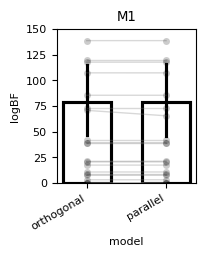

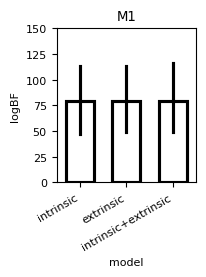

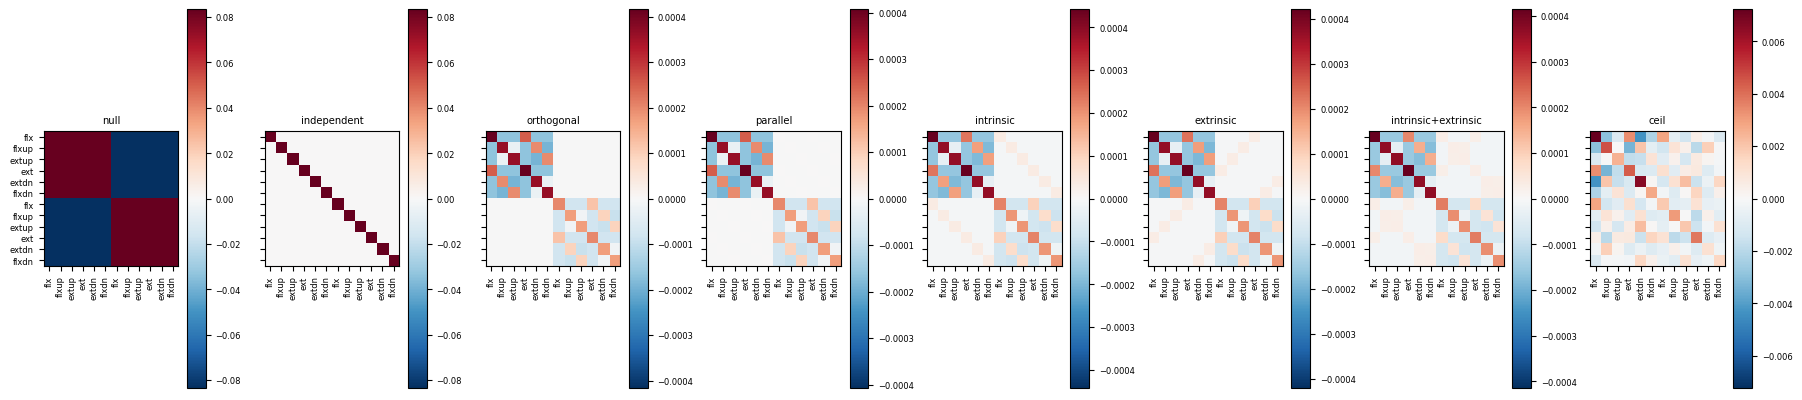

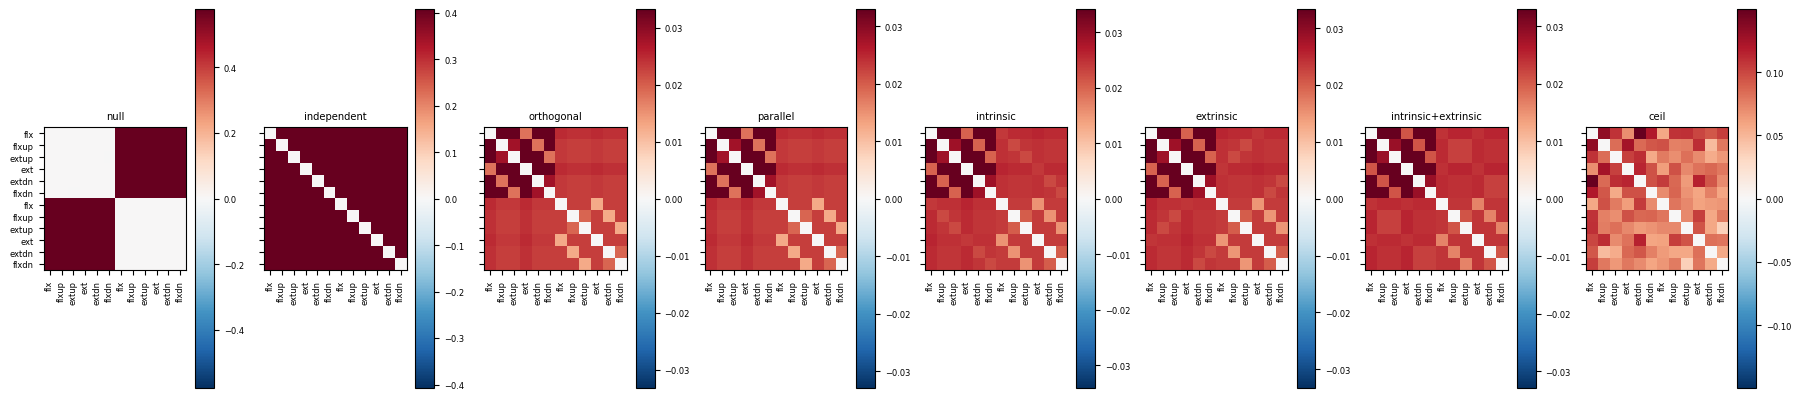

In [34]:
# load model fits:
import pickle
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'M1'

labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']

# load model fitting:
with open(os.path.join(analysisDir, f'PCM_unimanual_{region}.pkl'), 'rb') as f:
    results = pickle.load(f)

T_gr = results['T_gr']
theta_gr = results['theta_gr']
nmodels = len(theta_gr)
T_cv = results['T_cv']
theta_cv = results['theta_cv']

# ll_gr = T_gr.likelihood
# baseline = ll_gr.loc[:,'null'].values
# ll_gr = ll_gr - baseline.reshape(-1,1)
# ceil_gr = ll_gr['ceil'].values

# =============================== PLOT ===============================
sig_pairs = {'M1': [],
             'S1': [],
             'PMd': [[0,1]],
             'PMv': [[0,1]],
             'SMA': [[0,1]],
             'SPLa': [],
             'SPLp': [],
             'V1': [[0,1]]}

max_range = {'M1': 150,
             'S1': 700,
             'PMd': 200,
             'PMv': 400,
             'SMA': 400,
             'SPLa': 600,
             'SPLp': 700,
             'V1': 2000}

# Models:
M = []
modelG = {}

# Null model
# cov = np.zeros((ncond, ncond))
# M.append(pcm.FixedModel('null', cov))

# Simple hand model:
cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = 1
cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
cov = cov / np.trace(cov)
modelG['null'] = [cov]
M.append(pcm.FixedModel('null', cov))

# independent:
cov = np.eye(ncond) / ncond
modelG['independent'] = [cov]
M.append(pcm.FixedModel('independent', cov))

# Best model from unimanual direction encoding:
file_path = os.path.join(analysisDir, f'pcm_Ghat_best_within_model_{region}.npz')
data = np.load(file_path)
G_mdl = data['G_hat']
G_mdl = G_mdl / np.trace(G_mdl)

cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = G_mdl
# M.append(pcm.FixedModel('contra hand', cov))
modelG['contra_hand'] = [cov]

# Ipsi hand structure:
cov = np.zeros((ncond, ncond))
cov[6:12, 6:12] = G_mdl
# M.append(pcm.FixedModel('ipsi hand', cov))
modelG['ipsi_hand'] = [cov]

# Parallel contra-ipsi:
cov = np.eye(ncond) / 6
cov[0:6, 6:12] = G_mdl
cov[6:12, 0:6] = G_mdl
# cov = np.tile(G_ceil, (2,2))
# M.append(pcm.FixedModel('orth translation', cov))
cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
modelG['parallel'] = [cov]

# intrinsic contra-ipsi relationship:
cov = np.eye(ncond)
cov[0:6, 6:12] = np.eye(6)
cov[6:12, 0:6] = np.eye(6)
cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
cov = cov / np.trace(cov)
modelG['intrinsic'] = [cov]

# extrinsic contra-ipsi relationship:
mask_extrinsic = np.zeros((6,6)) # picking the extrinsicly similar conditions (moving to the same direction in space): e.g., flxup:extup, extdn:flxdn, ...
mask_extrinsic[0,3] = 1
mask_extrinsic[3,0] = 1
mask_extrinsic[1,2] = 1
mask_extrinsic[2,1] = 1
mask_extrinsic[4,5] = 1
mask_extrinsic[5,4] = 1
cov = np.eye(ncond)
cov[0:6, 6:12] = mask_extrinsic
cov[6:12, 0:6] = mask_extrinsic
cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
cov = cov / np.trace(cov)
modelG['extrinsic'] = [cov]

# component models:
M.append(pcm.ComponentModel('orthogonal', [modelG['null'][0],modelG['independent'][0],modelG['contra_hand'][0], modelG['ipsi_hand'][0]]))
M.append(pcm.ComponentModel('parallel', [modelG['null'][0],modelG['independent'][0],modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['parallel'][0]]))
M.append(pcm.ComponentModel('intrinsic', [modelG['null'][0],modelG['independent'][0],modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['intrinsic'][0]]))
M.append(pcm.ComponentModel('extrinsic', [modelG['null'][0],modelG['independent'][0],modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['extrinsic'][0]]))
M.append(pcm.ComponentModel('intrinsic+extrinsic', [modelG['null'][0],modelG['independent'][0],modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['intrinsic'][0], modelG['extrinsic'][0]]))

# noise ceiling model:
M_ceil = pcm.FreeModel('ceil',ncond)
M.append(M_ceil)

cmap = 'RdBu_r'
# set font:
matplotlib.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(1,1,figsize=(1.8,2))
likelihood = T_cv.likelihood
baseline = likelihood.loc[:,'null'].values
likelihood = likelihood - baseline.reshape(-1,1)
likelihood = likelihood.loc[:, (likelihood.columns == 'orthogonal') | (likelihood.columns == 'parallel')]
LL = likelihood.melt(var_name='model', value_name='logBF')
sns.barplot(data=LL, x='model', y='logBF', ax=ax, fill=False, color='k', width=0.6)
# sns.boxplot(data=LL, x='model', y='logBF', ax=ax, fill=False, color='k')
sns.stripplot(data=LL, x='model', y='logBF', ax=ax, color='k', size=5, jitter=False, alpha=0.2)
utils.please.draw_sig_lines(ax, LL, 'model', 'logBF', sig_pairs[region], 
                            plot_type='barplot', line_height_gap=1000, line_height_increase=6, height_tick=50)
# utils.please.draw_sig_lines(ax, sig_pairs[region], 1)
# connect the lines of same subjects between models:
for i in range(len(likelihood)):
    plt.plot(LL['model'].unique(), likelihood.iloc[i,:], color='gray', alpha=0.3, linewidth=1)

plt.xticks(rotation=30, ha='right')
plt.title(f'{region}')
# max_range = 300
ax.set_ylim((0, max_range[region]))
plt.show()

fig, ax = plt.subplots(1,1,figsize=(1.8,2))
likelihood = T_cv.likelihood
baseline = likelihood.loc[:,'null'].values
likelihood = likelihood - baseline.reshape(-1,1)
likelihood = likelihood.loc[:, (likelihood.columns == 'intrinsic') | (likelihood.columns == 'extrinsic') | (likelihood.columns == 'intrinsic+extrinsic')]
LL = likelihood.melt(var_name='model', value_name='logBF')
sns.barplot(data=LL, x='model', y='logBF', ax=ax, fill=False, color='k', width=0.6)
plt.xticks(rotation=30, ha='right')
plt.title(f'{region}')
ax.set_ylim((0, max_range[region]))
plt.show()

nmodels = len(M)
# set font:
matplotlib.rcParams.update({'font.size': 6})
# Plot model predictions:
fig, ax = plt.subplots(1, nmodels, figsize=(18,4), sharey=True)
for i in range(nmodels):
    G = M[i].predict(theta_gr[i][:M[i].n_param])[0]
    vmin = -np.max(np.abs(G))
    vmax = np.max(np.abs(G))
    ax[i].imshow(G, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(M[i].name)
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(G, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,nmodels, figsize=(18,4), sharey=True)
for i in range(nmodels):
    G = M[i].predict(theta_gr[i][:M[i].n_param])[0]
    D = pcm.G_to_dist(G)
    D = np.sign(D) * np.sqrt(np.abs(D))
    vmin = -np.max(np.abs(D))
    vmax = np.max(np.abs(D))
    ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(M[i].name)
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.tight_layout()
plt.show()




In [43]:
i = 2
tmp = theta_gr[i][:M[i].n_param]

np.exp(tmp)


array([1.39175668e-10, 6.60211913e-16, 2.27334761e-03, 1.09088253e-03])

# T-Test

In [28]:
# load model fits:
import pickle

regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
for region in regions:
    print(f'\n======================= processing {region} =======================')
    # load model fitting:
    with open(os.path.join(analysisDir, f'PCM_unimanual_{region}.pkl'), 'rb') as f:
        results = pickle.load(f)
    
    T_gr = results['T_gr']
    theta_gr = results['theta_gr']
    nmodels = len(theta_gr)
    T_cv = results['T_cv']
    theta_cv = results['theta_cv']

    # T-test between models:
    from scipy import stats
    likelihood = T_cv.likelihood
    m_names = likelihood.columns.values
    baseline = likelihood.loc[:,'null'].values
    likelihood = likelihood - baseline.reshape(-1,1)

    bayesfact = {'orthogonal': [], 'parallel': [], 'intrinsic': [], 'extrinsic': [], 'intrinsic+extrinsic': []}
    bayesfact['orthogonal'] = likelihood['orthogonal'].values
    bayesfact['parallel'] = likelihood['parallel'].values
    bayesfact['intrinsic'] = likelihood['intrinsic'].values
    bayesfact['extrinsic'] = likelihood['extrinsic'].values
    bayesfact['intrinsic+extrinsic'] = likelihood['intrinsic+extrinsic'].values

    # # ttest each model > 0:
    # ttests = {}
    # for k in bayesfact.keys():
    #     t, p = stats.ttest_1samp(bayesfact[k], 0, alternative='greater')
    #     mean = np.mean(bayesfact[k])
    #     std = np.std(bayesfact[k])
    #     sem = stats.sem(bayesfact[k])
    #     ttests[k] = {'t': t, 'p': p, 'dof': len(bayesfact[k])-1, 'mean': mean, 'std': std, 'sem': sem}
    #     print(f'{k}: t({ttests[k]["dof"]})={t:.2f}, p={p:.4f}, mean={mean:.2f} std={std:.2f} sem={sem:.2f}')

    # Model comparisons:
    #########################
    model2 = 'parallel'
    model1 = 'orthogonal'
    t, p = stats.ttest_rel(bayesfact[model2], bayesfact[model1], alternative='greater')
    mean_diff = np.mean(bayesfact[model2] - bayesfact[model1])
    std_diff = np.std(bayesfact[model2] - bayesfact[model1])
    sem_diff = stats.sem(bayesfact[model2] - bayesfact[model1])
    dof = len(bayesfact[model2]) - 1
    print(f"\n{model2} > {model1}:")
    print(f'    t-test {model2} > {model1}: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')
    wilcoxon_stat, wilcoxon_p = stats.wilcoxon(bayesfact[model2], bayesfact[model1], alternative='greater')
    print(f"    Wilcoxon W={wilcoxon_stat:.2f}, p-value={wilcoxon_p:.4e}")

    #########################
    model2 = 'extrinsic'
    model1 = 'orthogonal'
    t, p = stats.ttest_rel(bayesfact[model2], bayesfact[model1], alternative='greater')
    mean_diff = np.mean(bayesfact[model2] - bayesfact[model1])
    std_diff = np.std(bayesfact[model2] - bayesfact[model1])
    sem_diff = stats.sem(bayesfact[model2] - bayesfact[model1])
    dof = len(bayesfact[model2]) - 1
    print(f"\n{model2} > {model1}:")
    print(f'    t-test {model2} > {model1}: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')
    wilcoxon_stat, wilcoxon_p = stats.wilcoxon(bayesfact[model2], bayesfact[model1], alternative='greater')
    print(f"    Wilcoxon W={wilcoxon_stat:.2f}, p-value={wilcoxon_p:.4e}")

    #########################
    model2 = 'intrinsic'
    model1 = 'orthogonal'
    t, p = stats.ttest_rel(bayesfact[model2], bayesfact[model1], alternative='greater')
    mean_diff = np.mean(bayesfact[model2] - bayesfact[model1])
    std_diff = np.std(bayesfact[model2] - bayesfact[model1])
    sem_diff = stats.sem(bayesfact[model2] - bayesfact[model1])
    dof = len(bayesfact[model2]) - 1
    print(f"\n{model2} > {model1}:")
    print(f'    t-test {model2} > {model1}: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')
    wilcoxon_stat, wilcoxon_p = stats.wilcoxon(bayesfact[model2], bayesfact[model1], alternative='greater')
    print(f"    Wilcoxon W={wilcoxon_stat:.2f}, p-value={wilcoxon_p:.4e}")

    #########################
    model2 = 'intrinsic+extrinsic'
    model1 = 'orthogonal'
    t, p = stats.ttest_rel(bayesfact[model2], bayesfact[model1], alternative='greater')
    mean_diff = np.mean(bayesfact[model2] - bayesfact[model1])
    std_diff = np.std(bayesfact[model2] - bayesfact[model1])
    sem_diff = stats.sem(bayesfact[model2] - bayesfact[model1])
    dof = len(bayesfact[model2]) - 1
    print(f"\n{model2} > {model1}:")
    print(f'    t-test {model2} > {model1}: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')
    wilcoxon_stat, wilcoxon_p = stats.wilcoxon(bayesfact[model2], bayesfact[model1], alternative='greater')
    print(f"    Wilcoxon W={wilcoxon_stat:.2f}, p-value={wilcoxon_p:.4e}")

    #########################
    model2 = 'intrinsic+extrinsic'
    model1 = 'intrinsic'
    t, p = stats.ttest_rel(bayesfact[model2], bayesfact[model1], alternative='greater')
    mean_diff = np.mean(bayesfact[model2] - bayesfact[model1])
    std_diff = np.std(bayesfact[model2] - bayesfact[model1])
    sem_diff = stats.sem(bayesfact[model2] - bayesfact[model1])
    dof = len(bayesfact[model2]) - 1
    print(f"\n{model2} > {model1}:")
    print(f'    t-test {model2} > {model1}: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')
    wilcoxon_stat, wilcoxon_p = stats.wilcoxon(bayesfact[model2], bayesfact[model1], alternative='greater')
    print(f"    Wilcoxon W={wilcoxon_stat:.2f}, p-value={wilcoxon_p:.4e}")

    #########################
    model2 = 'intrinsic'
    model1 = 'extrinsic'
    t, p = stats.ttest_rel(bayesfact[model2], bayesfact[model1], alternative='two-sided')
    mean_diff = np.mean(bayesfact[model2] - bayesfact[model1])
    std_diff = np.std(bayesfact[model2] - bayesfact[model1])
    sem_diff = stats.sem(bayesfact[model2] - bayesfact[model1])
    dof = len(bayesfact[model2]) - 1
    print(f"\n{model2} > {model1}:")
    print(f'    t-test {model2} > {model1}: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')
    wilcoxon_stat, wilcoxon_p = stats.wilcoxon(bayesfact[model2], bayesfact[model1], alternative='two-sided')
    print(f"    Wilcoxon W={wilcoxon_stat:.2f}, p-value={wilcoxon_p:.4e}")

    #########################
    model2 = 'parallel'
    model1 = 'intrinsic+extrinsic'
    t, p = stats.ttest_rel(bayesfact[model2], bayesfact[model1], alternative='greater')
    mean_diff = np.mean(bayesfact[model2] - bayesfact[model1])
    std_diff = np.std(bayesfact[model2] - bayesfact[model1])
    sem_diff = stats.sem(bayesfact[model2] - bayesfact[model1])
    dof = len(bayesfact[model2]) - 1
    print(f"\n{model2} > {model1}:")
    print(f'    t-test {model2} > {model1}: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')
    wilcoxon_stat, wilcoxon_p = stats.wilcoxon(bayesfact[model2], bayesfact[model1], alternative='greater')
    print(f"    Wilcoxon W={wilcoxon_stat:.2f}, p-value={wilcoxon_p:.4e}")




======================= processing M1 =======================

parallel > orthogonal:
    t-test parallel > orthogonal: t(23)=-0.30, p=0.6180, mean_diff=-0.08 std_diff=1.26 sem_diff=0.26
    Wilcoxon W=187.00, p-value=1.5145e-01

extrinsic > orthogonal:
    t-test extrinsic > orthogonal: t(23)=0.26, p=0.3973, mean_diff=0.24 std_diff=4.29 sem_diff=0.89
    Wilcoxon W=174.00, p-value=2.5438e-01

intrinsic > orthogonal:
    t-test intrinsic > orthogonal: t(23)=-0.03, p=0.5137, mean_diff=-0.03 std_diff=4.73 sem_diff=0.99
    Wilcoxon W=162.00, p-value=3.7346e-01

intrinsic+extrinsic > orthogonal:
    t-test intrinsic+extrinsic > orthogonal: t(23)=0.32, p=0.3763, mean_diff=0.46 std_diff=6.96 sem_diff=1.45
    Wilcoxon W=167.00, p-value=3.2157e-01

intrinsic+extrinsic > intrinsic:
    t-test intrinsic+extrinsic > intrinsic: t(23)=0.63, p=0.2686, mean_diff=0.50 std_diff=3.81 sem_diff=0.79
    Wilcoxon W=189.00, p-value=1.3841e-01

intrinsic > extrinsic:
    t-test intrinsic > extrinsic: t(23

# Save ceiling for each region

In [40]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']

for region in regions:
    # load model fits:
    with open(os.path.join(analysisDir, f'PCM_unimanual_{region}.pkl'), 'rb') as f:
        results = pickle.load(f)

    T_gr = results['T_gr']
    theta_gr = results['theta_gr']
    nmodels = len(theta_gr)
    T_cv = results['T_cv']
    theta_cv = results['theta_cv']

    ceil_gr = T_gr.likelihood['ceil'].reset_index(drop=True)
    ceil_cv = T_cv.likelihood['ceil'].reset_index(drop=True)
    theta_gr = theta_gr[-1]
    theta_cv = theta_cv[-1]

    ceil = {
                'T_gr': T_gr, 'theta_gr': theta_gr,
                'T_cv': T_cv, 'theta_cv': theta_cv
                }
    with open(os.path.join(analysisDir, f'PCM_unimanual_ceil_{region}.pkl'), 'wb') as f:
        pickle.dump(ceil, f)

